### **BERT Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# libraries
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np

# !pip install tensorflow_text
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Fake News/News.csv")
data.head()

,Unnamed: 0,title,text,subject,date,Labels
0,0,GRAPHIC RIOT VIDEOS EXPOSE THUGS ATTACKING ELD...,youngers these days are becoming so moist pic....,politics,"Sep 22, 2016",Fake
1,1,BIG BROTHER: FEDS WANT YOUR DOCTOR TO WARN YOU...,totally out of bounds! This is so wrong and so...,Government News,"Jun 26, 2015",Fake
2,2,BLACK LIVES MATTER TERRORISTS May Be Shut Down...,ter ror ist ter r st/ noun a person who uses ...,politics,"Dec 23, 2015",Fake
3,3,EMBARRASSING: Obama Explains How He Will ‘Rebu...,re buke r byo ok/ verb 1. express sharp disapp...,left-news,"Nov 25, 2015",Fake
4,4,OHIO ELECTOR TORCHES Anti-Trump Letters He Rec...,pic.twitter.com/KMnLrwB6t1 Richard K. Jones (...,politics,"Dec 21, 2016",Fake


In [ ]:
data['Combined_text'] = data['title'] +' '+ data['text']

In [ ]:
data.drop(["title"],axis=1,inplace=True)
data.drop(["text"],axis=1,inplace=True)
data.drop(["date"],axis=1,inplace=True)
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head()

,subject,Labels,Combined_text
0,politics,Fake,GRAPHIC RIOT VIDEOS EXPOSE THUGS ATTACKING ELD...
1,Government News,Fake,BIG BROTHER: FEDS WANT YOUR DOCTOR TO WARN YOU...
2,politics,Fake,BLACK LIVES MATTER TERRORISTS May Be Shut Down...
3,left-news,Fake,EMBARRASSING: Obama Explains How He Will ‘Rebu...
4,politics,Fake,OHIO ELECTOR TORCHES Anti-Trump Letters He Rec...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(data['Labels'])


data['Labels'] = labels

In [ ]:
data.head()

,subject,Labels,Combined_text
0,politics,0,GRAPHIC RIOT VIDEOS EXPOSE THUGS ATTACKING ELD...
1,Government News,0,BIG BROTHER: FEDS WANT YOUR DOCTOR TO WARN YOU...
2,politics,0,BLACK LIVES MATTER TERRORISTS May Be Shut Down...
3,left-news,0,EMBARRASSING: Obama Explains How He Will ‘Rebu...
4,politics,0,OHIO ELECTOR TORCHES Anti-Trump Letters He Rec...


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.Combined_text, data.Labels, stratify=data.Labels, random_state=35)


In [ ]:
y_test.value_counts()

0    5871
1    5354
Name: Labels, dtype: int64

In [ ]:
X_train.head()

14069    U.N.'s Guterres warns against 'sleepwalking' i...
32500     Trump’s Right-hand Man Threatens ‘BLOODBATH’ ...
9908      WATCH: Girl On Bike Brutally Beaten By Cops A...
37364    China to push for greater cooperation on graft...
32607     Trump Threatens Government Shutdown If Congre...
Name: Combined_text, dtype: object

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):

    #confusion matrix
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    
    #Recall
    #divid each element of the confusion matrix with the sum of elements in that column
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #Precision Matrix
    #divide each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))
    
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Build Model

In [ ]:
bert_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessed = bert_preprocess(bert_input)
bert_outputs = bert_encoder(preprocessed)

# Neural network layers
neural_layer = tf.keras.layers.Dropout(0.1, name="dropout")(bert_outputs['pooled_output'])
final_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(neural_layer)

#final
bert_model = tf.keras.Model(inputs=[bert_input], outputs = [final_layer])

print(bert_model.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_24 (KerasLayer)    {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                   

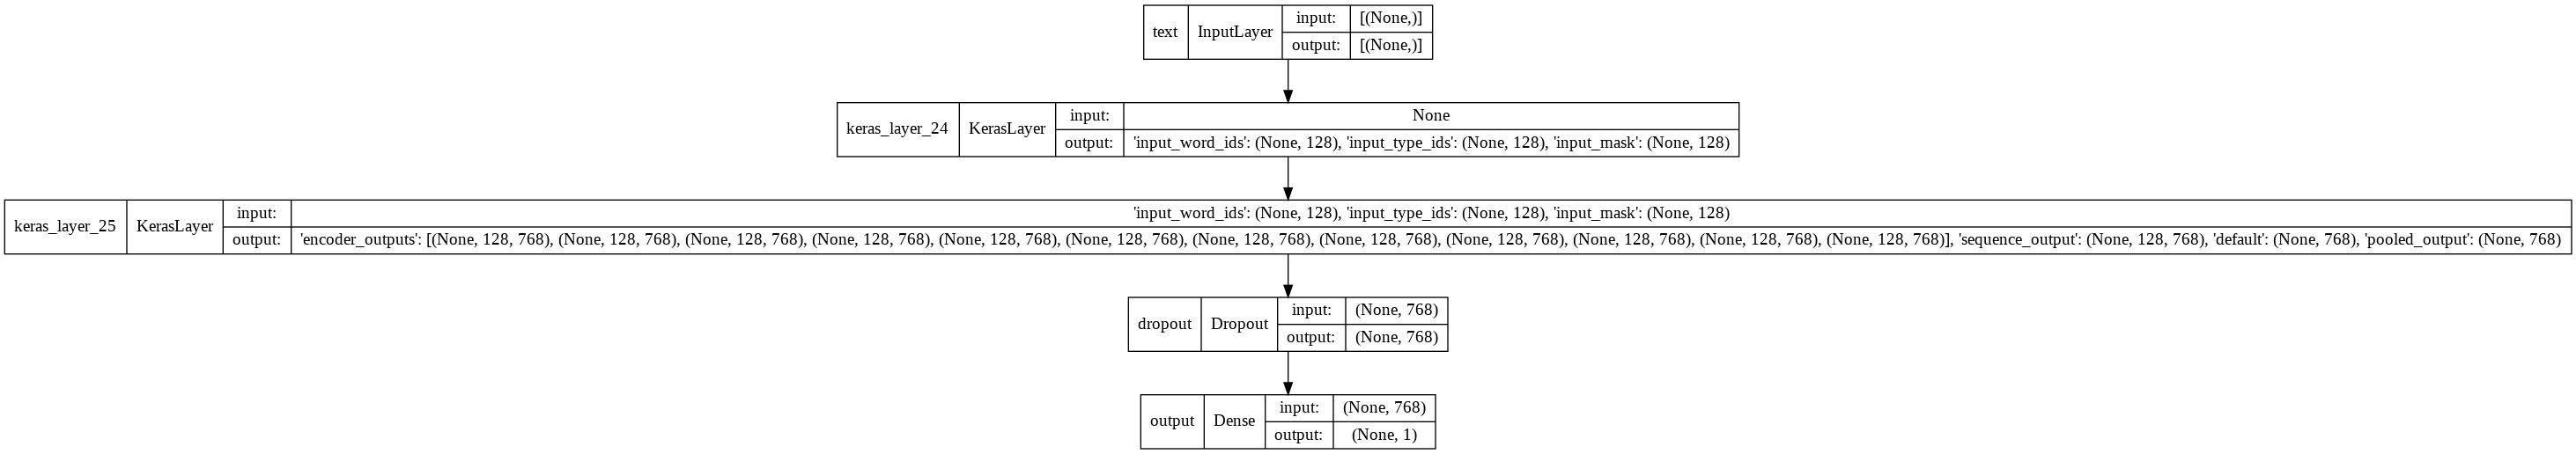

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(bert_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Training Model

In [ ]:
#compile model
bert_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=([
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')
                      ]))

#model fit
bert_model.fit(X_train, y_train, epochs=15)

Epoch 1/15
1053/1053 [==============================] - 235s 216ms/step - loss: 0.3290 - accuracy: 0.8762 - precision: 0.8766 - recall: 0.8617
Epoch 2/15
1053/1053 [==============================] - 228s 216ms/step - loss: 0.1934 - accuracy: 0.9311 - precision: 0.9308 - recall: 0.9242
Epoch 3/15
1053/1053 [==============================] - 227s 215ms/step - loss: 0.1678 - accuracy: 0.9378 - precision: 0.9369 - recall: 0.9325
Epoch 4/15
1053/1053 [==============================] - 227s 215ms/step - loss: 0.1546 - accuracy: 0.9422 - precision: 0.9412 - recall: 0.9374
Epoch 5/15
1053/1053 [==============================] - 227s 215ms/step - loss: 0.1456 - accuracy: 0.9451 - precision: 0.9454 - recall: 0.9393
Epoch 6/15
1053/1053 [==============================] - 227s 215ms/step - loss: 0.1403 - accuracy: 0.9477 - precision: 0.9478 - recall: 0.9422
Epoch 7/15
1053/1053 [==============================] - 227s 215ms/step - loss: 0.1366 - accuracy: 0.9489 - precision: 0.9475 - recall: 0.9453

Evaluating Model

In [ ]:
# model evaluation 
test_acc = bert_model.evaluate(X_test, y_test)
train_acc = bert_model.evaluate(X_train, y_train)
print('\n\n')
print("Train accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

1053/1053 [==============================] - 226s 215ms/step - loss: 0.0899 - accuracy: 0.9696 - precision: 0.9711 - recall: 0.9651



Train accuracy:  [0.08994603902101517, 0.9696195721626282, 0.9710598587989807, 0.9650750160217285]
Test accuracy:  [0.0940338522195816, 0.9680178165435791, 0.9686620235443115, 0.9641389846801758]


In [ ]:
def predicting_value(x_test, bert_Model, Y_test):

  # getting predicted value
  predicted_value = bert_Model.predict(x_test).flatten()
  predicted_value = np.where(predicted_value > 0.5, 1, 0)

  print(classification_report(Y_test, predicted_value))

  #plot confusion matrix
  plot_confusion_matrix(Y_test, predicted_value)
  print('\n')


  #plot roc curve
  from sklearn.metrics import roc_curve, auc
  fpr,tpr,ths = roc_curve(Y_test,predicted_value)
  auc_sc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % auc_sc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic with test data')
  plt.legend()
  plt.show()



              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5871
           1       0.97      0.96      0.97      5354

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



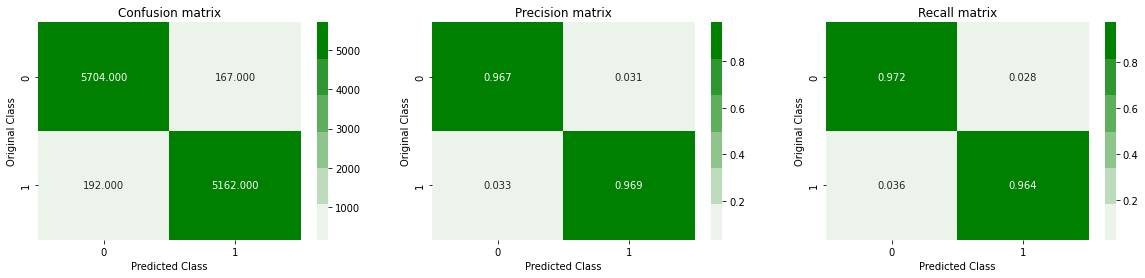

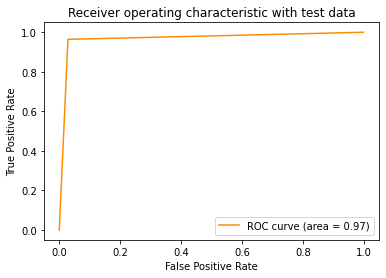

In [ ]:
predicting_value(X_test,bert_model,y_test)